# Ejercicio1: Imagen panorámica

Para resolver el ejercicio hay que rellenar el código que falta en las celdas correspondientes.

En este ejercicio vamos a crear una imagen panorámica. Para realizar este procesamiento vamos a trabajar primero con el algoritmo SIFT (_Scale Invariant Feature Transform_) con el que se detectan puntos de interés y se calculan sus descriptores. A continuación obtendremos la correspondencia de los puntos de interés mediante fuerza bruta. Finalmente calcularemos la homografía y la aplicaremos a una de las imágenes para construir la imagen panorámica.

## Importa las librerías opencv, numpy y matplotib

In [1]:
# Importa opencv
# Importa numpy
# Importar matplotlib
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Lee y visualiza las dos imágenes con las que se construirá la imagen panorámica

Lee y visualiza con matplotlib las imágenes _ImagenPanoramica_1.png_ (target) y _ImagenPanoramica_2.png_ (source).

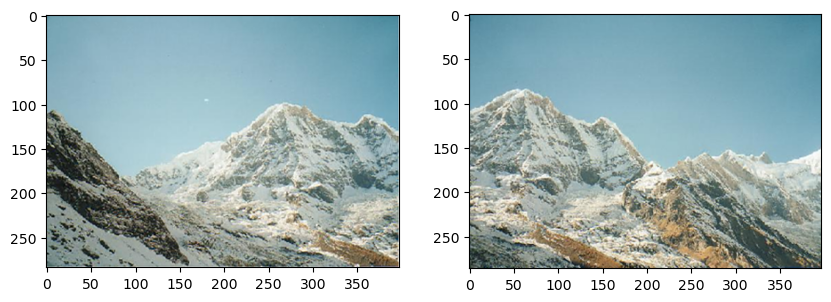

In [3]:
img1BGR = cv.imread('ImagenPanoramica_1.png') # Lee ImagenPanoramica_1.png 
img1 = cv.cvtColor(img1BGR, cv.COLOR_BGR2RGB) # Convierte a RGB
img2BGR = cv.imread('ImagenPanoramica_2.png') # Lee ImagenPanoramica_2.png
img2 = cv.cvtColor(img2BGR, cv.COLOR_BGR2RGB) # Convierte a RGB

plt.figure(figsize=(10, 6)) # Crea una nueva figura (matplotlib)
plt.subplot(1,2,1) # Selecciona subfigura a la izquierda
plt.imshow(img1) # Visualiza la imagen 1
plt.subplot(1,2,2) # Selecciona subfigura a la derecha
plt.imshow(img2) # Visualiza la imagen 2

## Obtén los puntos de interés y sus descriptores de cada imagen

Para detectar los puntos de interés y calcular sus descriptores de cada imagen (en escala de grises, no en color) vamos a utilizar la clase [_SIFT_](https://docs.opencv.org/4.x/d7/d60/classcv_1_1SIFT.html) y el método [detectAndCompute](https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677) y no se va a utilizar ninguna máscara. Realiza este procesado para ambas imágenes.

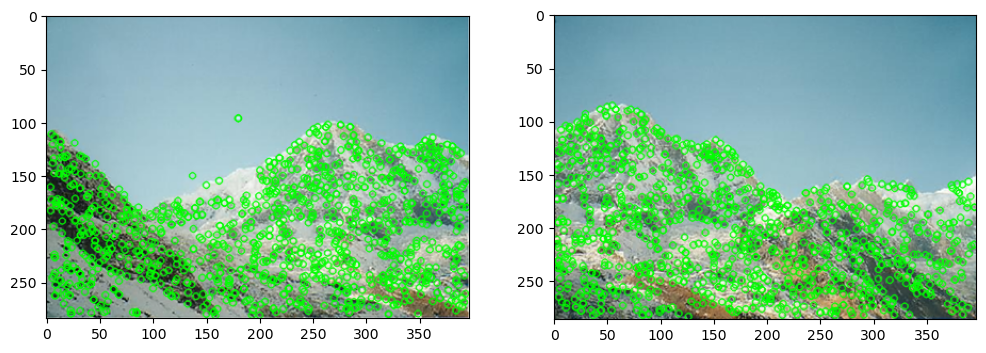

In [6]:
sift = cv.SIFT_create() # Instancia de clase SIFT

img1Gris = cv.cvtColor(img1BGR, cv.COLOR_BGR2GRAY) # Convierte a escala de grises la imagen 1
kp1, descrip1 = sift.detectAndCompute(img1Gris, None) # Detecta puntos de interés, calcula descriptores (imagen 1), sin máscara
img1_kp1 = cv.drawKeypoints(img1, kp1, None, color=(0,255,0)) # Dibuja los puntos de interés en la imagen 1 (color)

img2Gris = cv.cvtColor(img2BGR, cv.COLOR_BGR2GRAY) # Convierte a escala de grises la imagen 2
kp2, descrip2 = sift.detectAndCompute(img2Gris, None) # Detecta puntos de interés, calcula descriptores (imagen 1), sin máscara
img2_kp2 = cv.drawKeypoints(img2, kp2, None, color=(0,255,0)) # Dibuja los puntos de interés en la imagen 2 (color)

plt.figure(figsize=(12, 6)) # Crea una nueva figura (matplotlib)
plt.subplot(1,2,1) # Selecciona subfigura a la izquerda
plt.imshow(img1_kp1) # Visualiza la imagen 1 con los puntos de interés
plt.subplot(1,2,2) # Selecciona subfigura a la derecha
plt.imshow(img2_kp2) # Visualiza la imagen 2 con los puntos de interés

## Obtén la correspondencia entre descriptores de ambas imágenes

Para obtener la mejor correspondencia entre cada descriptor de una imagen (_queryDescriptors_, primer parámetro de método _match_, en nuestro caso los descriptores de _source_ que son los de la imagen 2) y los descriptores de otra imagen (_trainDescriptors_, segundo parámetro de método _match_, en nuestro caso los descriptores de _target_ que son los de la imagen 1) vamos a utilizar la fuerza bruta empleando la clase de opencv [_BFMatcher_](https://docs.opencv.org/4.x/d3/da1/classcv_1_1BFMatcher.html) con norma L2 y el método [_match_](https://docs.opencv.org/4.x/db/d39/classcv_1_1DescriptorMatcher.html#a0f046f47b68ec7074391e1e85c750cba). Después se ordenan las correspondencias con la función [_sorted_](https://docs.python.org/es/3/library/functions.html#sorted) de Python y una expresión lambda para obtener la propiedad _distance_ de cada correspondencia. Se van a seleccionar las 50 correspondencias con menores distancias. Visualiza con matplotlib las correspondencias con la función [_drawMatches_](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a) de opencv con el parámetro _flags=2_ (NOT_DRAW_SINGLE_POINTS). Importante en método _drawMatches_: mismo orden de los datos que en método _match_.

La expresión lambda en Python es una forma corta de declarar funciones pequeñas y anónimas. Sintaxis: _lambda argumentos: expresión_.

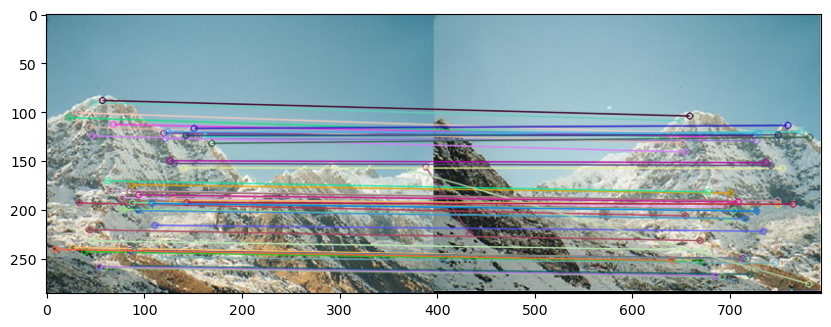

In [7]:
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True) # Crea una instancia de la clase BFMatcher con norma L2 y 1 vecino más próximo por cada descriptor
allMatches = bf.match(descrip2, descrip1) # Encuentra la correspondencia entre descriptores de ambas imágenes
allMatchesSorted = sorted(allMatches, key = lambda x:x.distance) # Ordena la correspondencia por la propiedad distancia
matches = allMatchesSorted[:50] #  50 correspondencias con menores distancias

imgMatches = cv.drawMatches(img2, kp2, img1, kp1, matches, None, flags=2) # flags=2 -- NOT_DRAW_SINGLE_POINTS
plt.figure(figsize=(10, 6)) # Crea una nueva figura (matplotlib)
plt.imshow(imgMatches) # Visualize imgMatches

## Calcula la homografía

Convierte las coordenadas de los puntos de interés de ambas imágenes a arrays de numpy. Después calcula la homografía con las 50 correspondencias (pares de puntos de interés) con menores distancias. Para calcular la homografía, los puntos de interés de la imagen objetivo corresponden con los de _ImagenPanoramica_1.png_.

En este caso, en [_findHomography_](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780) se utiliza el algorimo RANSAC con un error de retroproyección máximo de 5 píxeles (si es mayor el error de retroproyección, punto se considera un _outlier_).

In [9]:
src_pts = np.array([ kp2[m.queryIdx].pt for m in matches ]) # Puntos de interés de la imagen a deformar (source)
dst_pts = np.array([ kp1[m.trainIdx].pt for m in matches ]) # Puntos de interés correspondientes de la imagen objetivo (target)
h, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5) # Calcula la homografía

## Construye la imagen panorámica

Construye la imagen panorámica con los siguientes pasos y visualiza la imagen panorámica con matplotlib.
* Aplica la homografía a la imagen _ImagenPanoramica_2.png_ y ten en cuenta que la imagen panorámica tiene que tener la misma altura que la imagen _ImagenPanoramica_1.png_ y su anchura es la suma de las anchuras de las dos imágenes que se quieren unir. 
* Sustituye en la imagen panorámica los valores de los píxeles correspondientes a la imagen _ImagenPanoramica_1.png_.

(284, 397, 3) (286, 397, 3) 794


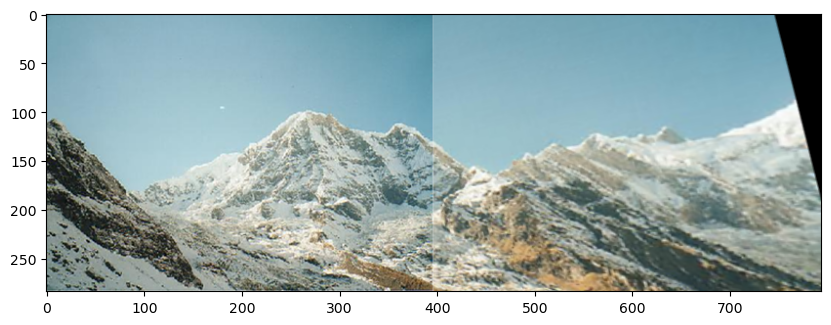

In [20]:
tam_dst = img1BGR.shape
tam_dst2 = img2BGR.shape
anchura = tam_dst[1] + tam_dst2[1]
print(tam_dst, tam_dst2, anchura)
panoramica = cv.warpPerspective(img2, h, (anchura,tam_dst[0])) # Deforma ImagenPanoramica_2.png
panoramica[:, 0:img1.shape[1], :] = img1# Incluye los valores de ImagenPanoramica_1.png
plt.figure(figsize=(10, 6)) # Crea una nueva figura (matplotlib)
plt.imshow(panoramica) # Visualiza la imagen panorámica